Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Alejandro Puerto Castro"
COLLABORATORS = "Gonzalo Peraza"

---

# Unsupervised Feature Selection

Feature selection is a dimensionality reduction method that keeps a low dimensional subset of the original features of original feature space. Contrary to feature extraction, feature selection techniques do not transform the features, maintaining the original meaning improving interpretability of the results of machine learning algorithms.

For example, take the figure from Ref [1] below.  In (a), feature $f_1$ is a relevant feature that is able to discriminate two classes (clusters). However, given feature $f_1$, feature $f_2$ (b) is redundant as $f_2$ is strongly correlated with $f_1$ . In (c), feature $f_3$ is an irrelevant feature, as it cannot separate two classes (clusters) at all. Therefore, the removal of $f_2$ and $f_3$ will not negatively impact the learning performance.

![](Figures/selection1.png)



Feature selection can be either supervised, unsupervised, or semi-supervised. Supervised selection uses class information to asses the relevance of each feature.  It aims to select a subset of features that are able to discriminate samples from different classes. With supervision information, feature relevance is usually assessed via its correlation with the class labels or the regression target.

Unsupervised feature selection is generally designed for clustering problems. Without label information to evaluate the importance of
features, unsupervised feature selection methods seek alternative criteria to define feature relevance. Selection methods can be classified into:

- Filter methods: Independent of the unsupervised learning algorithms. They rely on characteristics of data to assess feature importance. Filter methods are typically more computationally efficient than wrapper methods. However, due to the lack of a specific learning algorithm guiding the feature selection phase, the selected features may not be optimal for the target learning algorithms. A typical filter method consists of two steps. In the first step, feature importance is ranked according to some feature evaluation criteria. The feature importance evaluation process can be either univariate or multivariate. In the univariate scheme, each feature is ranked individually regardless of other features, while the multivariate scheme ranks multiple features in a batch way. In the second step of a typical filter method, lowly ranked features are filtered out. 

- Wrapper methods:  Rely on the learning algorithms to iteratively improve the quality of selected features. Given a specific learning algorithm, a typical wrapper method performs two steps: (1) searches for a subset of features and (2) evaluates the selected features. It repeats (1) and (2) until some stopping criteria are satisfied. The feature set search component first generates a subset of features, and then the learning algorithm acts as a black box to evaluate the quality of these features based on the learning performance. For example, the whole process works iteratively until the highest learning performance is achieved or the desired number of selected features is obtained. Then the feature subset that gives the highest learning performance is returned as the selected features. Unfortunately, a known issue of wrapper methods is that the search space for d features is 2d , which is impractical when d is very large. As a result, wrapper methods are seldom used in practice.

- Embedded methods: embeds the feature selection phase into unsupervised learning algorithms. Embedded methods is a tradeoff between filter and wrapper methods that embed the feature selection into model learning. Thus they inherit the merits of wrapper and filter methods: (1) They include the interactions with the learning algorithm and (2) they are far more efficient than the wrapper methods, since they do not need to evaluate feature sets iteratively. The most widely used embedded methods are the regularization models that target to fit a learning model by minimizing the fitting errors and forcing feature coefficients to be small (or exact zero) simultaneously. Afterwards, both the regularization model and selected feature sets are returned as the final results.




## Datasets

### Iris dataset

The Iris data set contains 3 classes and 50 instances of each class, where each class refers to a type of Iris plant. Each instance is characterized by four features, i.e., sepal length, sepal width, petal length, and petal width. One class is linearly separable from the other two,but the other two are not linearly separable from each other. Of the four features, the third and the fourth are known to be more important for class discrimination.

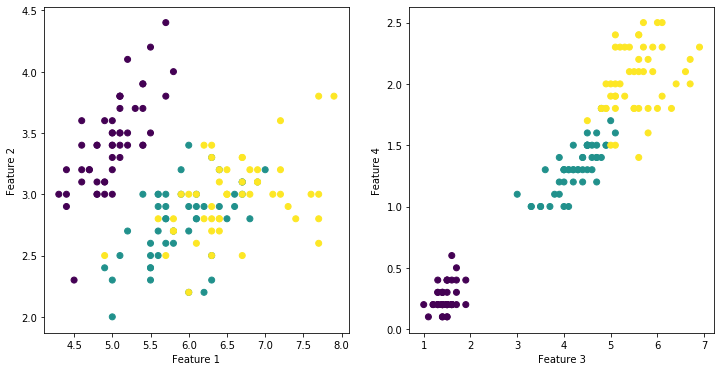

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

dataset = load_iris()
X = dataset['data']
y = dataset['target']

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].set_ylabel('Feature 2')
ax[0].set_xlabel('Feature 1')
ax[1].scatter(X[:,2], X[:,3], c=y)
ax[1].set_ylabel('Feature 4')
ax[1].set_xlabel('Feature 3');

In [3]:
print('The class correlation for each feature is:')
for i in range(4):
    cor = np.corrcoef(X[:,i], y)[0,1]
    print(f'\tF{i}: {cor:0.4f}')

The class correlation for each feature is:
	F0: 0.7826
	F1: -0.4267
	F2: 0.9490
	F3: 0.9565


## Similarity based Methods

These methods infer feature relevance from their ability to preserve data similarity. For unsupervised feature selection, these methods measure data similarity through the use of different distance metrics. 

### Laplacian score

Laplacian Score  is an unsupervised feature selection algorithm that selects features that can best preserve the data manifold structure. It consists of three phases:

1. Construct an affinity matrix
$$
S_{i,j} = 
\begin{cases}
\exp\left(-\frac{\lVert x_i -x_j\rVert^2}{t}\right) & \text{if $x_i$($x_j$) is among the p-nearest neighbors of $x_j$($x_i$)}\\
0 & \text{otherwise}
\end{cases}
$$

2. Construct the diagonal matrix as a sum over rows of S, this matrix gives information about the degree of connectivity of $x_i$:
$$
D_{i,i} = \sum_{j=1}^n S_{i,j}
$$
and the Laplacian matrix
$$
L = D - S
$$

3. Calculate the Laplacian score ($L_i$) if feature $f_i$ as
$$
score(f_i) = \frac{\tilde{f}_i^T L \tilde{f}_i}{\tilde{f}_i^T D \tilde{f}_i},
$$
where
$$
\tilde{f}_i = f_i - \frac{\tilde{f}_i^T D \tilde{f}_i}{\mathbf{1}^T D \mathbf{1}}\mathbf{1}
$$

Finally, one selects the $k$ features with the lowest Laplacian score.

The idea behind Laplacian Score, is that the matrix S encodes a weighted nearest neighbor graph. The score then reflects how well feature $i$ preserves the original graph structure (for more details, wait until the explanation of spectral clustering in unit 3).



In [4]:
def laplacian_score(X, k, t=1.0):
    m, n = X.shape
    ones = np.ones(m)
    
    # Find Squared Distance Matrix.
    sq_dist = ((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=-1)
    
    # Find the neighbor graph G.
    # Set xij = 1 if points are neighbors, 0 otherwise.
    neighbor_idx = np.argsort(sq_dist)[:, 1:k+1]
    G = np.zeros((m, m))
    # YOUR CODE HERE
    for i in range(m):
        G[i, neighbor_idx[i]] = 1
    #raise NotImplementedError()
        
    # Find the matrix S. Element-wise multiply exp(-sq_dist/t) and G
    # YOUR CODE HERE
    S = np.exp(-sq_dist/t) * G
    #raise NotImplementedError()
    
    # Find the diagonal matrix D
    # YOUR CODE HERE
    D = np.diag(np.dot(S, ones))
    #raise NotImplementedError()
        
    L = D - S
        
    # Normalize each feature and find the score
    scores = []
    for f in X.T:
        # YOUR CODE HERE
        var1 = f[:, None].T @ D @ ones
        var2 = ones[:, None].T @ D @ ones
        f_hat = f - (var1 / var2)
        var3 = f_hat.T @ L @ f_hat
        var4 = f_hat.T @ D @ f_hat
        scores.append(var3 / var4)
        #raise NotImplementedError()
    return np.array(scores)

In [5]:
laplacian_score(X, 5).argsort()
# Note: The orginal paper claims that choosing k < 15 sould change the ranking order.
# I have been unable to reproduce this, but they also omit to specify the value of t.
# Trying several t values, the ranking changes when t is very small (order 1e-3), but in the expected way.
# Try to veirfy this yourselves.

array([2, 3, 0, 1], dtype=int64)

You should obtain the ranking $f_3$,$f_4$,$f_1$,$f_2$, verifying that the two most important features are indeed $f_3$ and $f_4$.

### SPEC

Generalizes Laplacian Score.

## Sparse-Learning-Based Methods

### MCFS

### UDFS

### NDFS

## Statistical-Based Methods

### Low-Variance

This method just states that the features with the lowest variance should also be the less useful for class discrimination. This of course is not useful if we choose to normalize the dataset.

In [ ]:
def variance_selection(X):
    variances = []
    # YOUR CODE HERE
    raise NotImplementedError()
    return np.array(variances)

In [ ]:
variance_selection(X).argsort()[::-1]

You should obtain the ranking $f_2$,$f_1$,$f_4$,$f_2$.

## Methods for Linked Data

### LUFS

### NetFS

## Multi-Source Methods

### GDCOV

## Multiview Methods

### AUMFS

### MVFS

## Streaming Methods

### USFS

### FSDS

## References

1. Feature Selection: A Data Perspective, Li et.al., 2017
2. Laplacian Score for feature selection, He et.al., 2006